In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Sun Feb  4 18:16:08 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        Off | 00000000:19:00.0 Off |                  Off |
| 36%   57C    P8              33W / 300W |    403MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Hyper-Parameters

In [3]:
from easydict import EasyDict
hp = EasyDict()

# Data
hp.dataset = 'cifar10'
hp.data_root = '/home/scpark/data'
hp.test_eval = True
hp.image_size = 32
hp.image_channels = 3
hp.n_batch = 32

# Model
hp.custom_width_str = ""
hp.bottleneck_multiple = 0.25
hp.no_bias_above = 64
hp.num_mixtures = 10
hp.width = 384
hp.zdim = 16
hp.dec_blocks = "1x1,4m1,4x2,8m4,8x5,16m8,16x10,32m16,32x21"
hp.enc_blocks = "32x11,32d2,16x6,16d2,8x6,8d2,4x3,4d4,1x3"

# Train
hp.lr = 0.0002
hp.wd = 0.01
hp.adam_beta1 = 0.9
hp.adam_beta2 = 0.9
hp.warmup_iters = 100
hp.ema_rate = 0.9999
hp.grad_clip = 200.0
hp.skip_threshold = 400.0

### Model

In [4]:
from model.main.vdvae import Model
from model.encoder.vdvae_encoder import Encoder
from model.decoder.vdvae_decoder import Decoder
from model.loss.dmol import Loss

from tensorboardX import SummaryWriter
from util.util import *

In [5]:
step = 0
device = 'cuda:0'

model = Model(Encoder(hp), Decoder(hp), Loss(hp)).to(device)
ema_model = None
optimizer = torch.optim.AdamW(model.parameters(), weight_decay=hp.wd, lr=hp.lr, betas=(hp.adam_beta1, hp.adam_beta2))

for name, module in model.named_modules():
    if len(name.split('.')) <= 1 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 28.6021728515625
decoder 120.5799560546875
loss 0.1468658447265625
done


### Load

In [6]:
save_dir = '/data/save/lse/train_vdvae/train02.04-1/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if True:
    step, model, optimizer = load(save_dir, 11204, model, optimizer)

total 1381476
-rw-rw-r-- 1 scpark scpark        40  2월  4 18:16 events.out.tfevents.1707038116.scpark-X299-WU8
-rw-rw-r-- 1 scpark scpark    151330  2월  4 18:15 events.out.tfevents.1707034836.scpark-X299-WU8
-rw-rw-r-- 1 scpark scpark        40  2월  4 18:15 events.out.tfevents.1707038104.scpark-X299-WU8
-rw-rw-r-- 1 scpark scpark 471476702  2월  4 18:15 save_11204
-rw-rw-r-- 1 scpark scpark 471476702  2월  4 18:09 save_10000
-rw-rw-r-- 1 scpark scpark 471448894  2월  4 17:20 save_0
-rw-rw-r-- 1 scpark scpark       682  2월  4 17:20 events.out.tfevents.1707034621.scpark-X299-WU8
-rw-rw-r-- 1 scpark scpark     16735  2월  4 17:12 events.out.tfevents.1707033971.scpark-X299-WU8
-rw-rw-r-- 1 scpark scpark      2281  2월  4 17:06 events.out.tfevents.1707030312.scpark-X299-WU8
-rw-rw-r-- 1 scpark scpark        40  2월  4 16:05 events.out.tfevents.1707030275.scpark-X299-WU8
-rw-rw-r-- 1 scpark scpark        40  2월  4 16:04 events.out.tfevents.1707030252.scpark-X299-WU8
-rw-rw-r-- 1 scpark scpark     

### Dataset

In [7]:
from torch.utils.data import DataLoader
from data.vdvae_data import set_up_data

hp, data_train, data_valid_or_test, preprocess_fn = set_up_data(hp)
train_loader = DataLoader(data_train, batch_size=hp.n_batch, drop_last=True, pin_memory=True)
print(train_loader)

DOING TEST


### Train

In [8]:
import time
from util.train_helpers import update_ema

def training_step(H, data_input, target, model, ema_model, optimizer):
    model.train()
    model.zero_grad()
    data = {'x': data_input,
            'x_target': target}
    stats = model.forward(data)
    stats['elbo'].backward()
    grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), H.grad_clip).item()
    distortion_nans = torch.isnan(stats['distortion']).sum()
    rate_nans = torch.isnan(stats['rate']).sum()
    stats.update(dict(rate_nans=0 if rate_nans == 0 else 1, distortion_nans=0 if distortion_nans == 0 else 1))

    skipped_updates = 1
    # only update if no rank has a nan and if the grad norm is below a specific threshold
    if stats['distortion_nans'] == 0 and stats['rate_nans'] == 0 and (H.skip_threshold == -1 or grad_norm < H.skip_threshold):
        optimizer.step()
        skipped_updates = 0
        if ema_model is not None:
            update_ema(model, ema_model, H.ema_rate)

    stats.update(skipped_updates=skipped_updates, grad_norm=grad_norm)
    return stats

def show_samples(model, N):
    model.eval()
    with torch.no_grad():
        samples = model.sample(N)
    plt.figure(figsize=[18, 4])
    for i in range(len(samples)):
        plt.subplot(1, N, i+1)
        plt.imshow(samples[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

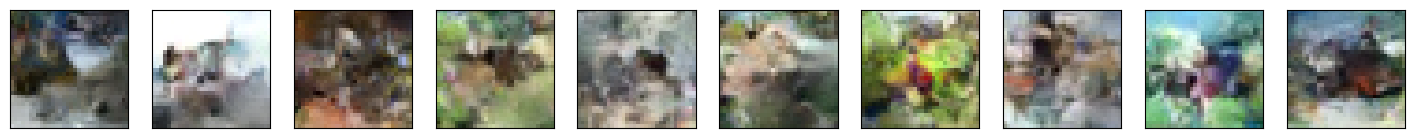

12010 elbo 2.7648372650146484
12020 elbo 2.558932065963745
12030 elbo 2.7475802898406982
12040 elbo 2.764787435531616
12050 elbo 2.7325079441070557
12060 elbo 2.6743202209472656
12070 elbo 2.5714774131774902
12080 elbo 2.720726490020752
12090 elbo 2.716560125350952
12100 elbo 2.675112247467041
12110 elbo 2.671311378479004
12120 elbo 2.7877326011657715
12130 elbo 2.61752986907959
12140 elbo 2.6058826446533203
12150 elbo 2.7985801696777344
12160 elbo 2.9018235206604004
12170 elbo 2.7511630058288574
12180 elbo 2.6756529808044434
12190 elbo 2.665846347808838
12200 elbo 2.6725716590881348
12210 elbo 2.562072992324829
12220 elbo 2.7294669151306152
12230 elbo 2.768690586090088
12240 elbo 2.592026948928833
12250 elbo 2.5781569480895996
12260 elbo 2.776427745819092
12270 elbo 2.7496161460876465
12280 elbo 2.702497959136963
12290 elbo 2.6842308044433594
12300 elbo 2.6451454162597656
12310 elbo 2.814584732055664
12320 elbo 2.682572603225708
12330 elbo 2.6623854637145996
12340 elbo 2.7159962654113


KeyboardInterrupt



In [9]:
import matplotlib.pyplot as plt
from IPython import display

while True:
    for x in train_loader:
        data_input, target = preprocess_fn(x)
        data_input = data_input.to(device)
        target = target.to(device)
        stats = training_step(hp, data_input, target, model, ema_model, optimizer)

        if step % 10 == 0:
            print(step, 'elbo', stats['elbo'].item())
            writer.add_scalar('elbo', stats['elbo'].item(), step)
            writer.add_scalar('distortion', stats['distortion'].item(), step)
            writer.add_scalar('rate', stats['rate'].item(), step)
            
        if step % 1000 == 0:
            display.clear_output()
            show_samples(model, 10)
            
        if step % 10000 == 0:
            save(save_dir, step, model, optimizer)
                
        step += 1
        

In [10]:
save(save_dir, step, model, optimizer)
print('done')

done
